# hbase data
![hbase](https://hbase.apache.org/images/hbase_logo_with_orca_large.png)

## 1. set hbase client

In [1]:
import os

import geopandas as gpd
import nest_asyncio
from dotenv import load_dotenv

from h3_toolkit.core import H3Toolkit

load_dotenv()
nest_asyncio.apply()   # needed for jupyter notebook to run asyncio
FETCH_API = os.getenv("HBASE_FETCH_API")
SEND_API = os.getenv("HBASE_SEND_API")
TOKEN = os.getenv("HBASE_TOKEN")

In [2]:
from h3_toolkit.hbase import HBaseClient

toolkit = H3Toolkit()
toolkit.set_hbase_client(
    HBaseClient(
        fetch_url=FETCH_API,
        send_url=SEND_API,
        token = TOKEN,
        max_concurrent_requests=5, # don't change this
        chunk_size=200000,         # don't change this
    )
)

## 2. Select boundary of the data

<Axes: >

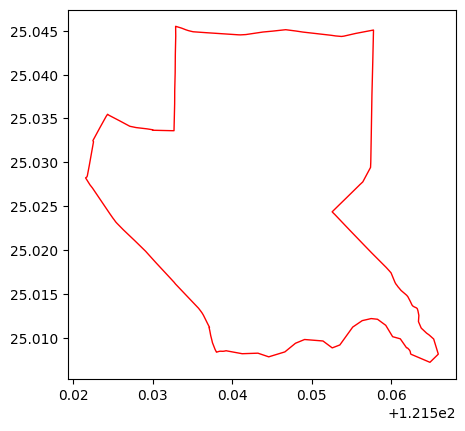

In [3]:
gdf = gpd.read_file('data/test_geom.geojson')
merged_geometry = gdf['geometry'].union_all()

new_gdf = gpd.GeoDataFrame(geometry=[merged_geometry], crs= gdf.crs)
new_gdf.plot(edgecolor='red', facecolor='none')

In [5]:
result = (
    toolkit
    .process_from_vector(
        data = new_gdf,
        resolution = 12,
        geometry_col = 'geometry'
    )
)

result.get_result().head()

hex_id
str
"""8c4ba0a406403ff"""
"""8c4ba0a406411ff"""
"""8c4ba0a406413ff"""
"""8c4ba0a406415ff"""
"""8c4ba0a406417ff"""


In [6]:
result = (
    toolkit
    .fetch_from_hbase(
        table_name = 'res12_pre_data',
        column_family = 'demographic',
        column_qualifier = ['p_cnt', 'f_cnt', 'm_cnt'],
    )
)

result.get_result().head()

hex_id,f_cnt,m_cnt,p_cnt
str,str,str,str
"""8c4ba0a406403ff""","""0.5666666666666667""","""0.5666666666666667""","""1.1333333333333333"""
"""8c4ba0a406411ff""","""0.5666666666666667""","""0.5666666666666667""","""1.1333333333333333"""
"""8c4ba0a406413ff""","""0.5666666666666667""","""0.5666666666666667""","""1.1333333333333333"""
"""8c4ba0a406415ff""","""0.5666666666666667""","""0.5666666666666667""","""1.1333333333333333"""
"""8c4ba0a406417ff""","""0.5666666666666667""","""0.5666666666666667""","""1.1333333333333333"""


## 3. Chain all steps together

In [8]:
from h3_toolkit import H3Toolkit
from h3_toolkit.hbase import HBaseClient

toolkit = H3Toolkit()

result = (
    toolkit
    .process_from_vector(
        data = new_gdf,
        resolution = 12,
        geometry_col = 'geometry'
    )
    .set_hbase_client(
        HBaseClient(
            fetch_url=FETCH_API,
            send_url=SEND_API,
            token = TOKEN,
            max_concurrent_requests=5, # don't change this
            chunk_size=200000,         # don't change this
        )
    )
    .fetch_from_hbase(
        table_name = 'res12_pre_data',
        column_family = 'demographic',
        column_qualifier = ['p_cnt'],
    )
    .get_result(return_geometry=True)
)

result.head()

,p_cnt,geometry
0,1.1333333333333333,"POLYGON ((121.52403 25.03519, 121.52401 25.035..."
1,1.1333333333333333,"POLYGON ((121.52431 25.03532, 121.5243 25.0352..."
2,1.1333333333333333,"POLYGON ((121.52449 25.03531, 121.52447 25.035..."
3,1.1333333333333333,"POLYGON ((121.5242 25.03518, 121.52419 25.0350..."
4,1.1333333333333333,"POLYGON ((121.52438 25.03518, 121.52436 25.035..."


## 4. fetch data from hbase and aggregate new data back to hbase


In [11]:
from h3_toolkit import H3Toolkit
from h3_toolkit.aggregation import SumUp, Mean
from h3_toolkit.hbase import HBaseClient

toolkit = H3Toolkit()

result = (
    toolkit
    .process_from_vector(
        data = new_gdf,
        resolution = 12,
        geometry_col = 'geometry'
    )
    .set_hbase_client(
        HBaseClient(
            fetch_url=FETCH_API,
            send_url=SEND_API,
            token = TOKEN,
        )
    )
    .fetch_from_hbase(
        table_name = 'res12_pre_data',
        column_family = 'demographic',
        column_qualifier = ['p_cnt', 'f_cnt', 'm_cnt'],
    )
    .set_aggregation_strategy(
        {
            ('f_cnt', 'p_cnt'): SumUp(),
            'm_cnt': Mean(),
        }
    )
    .process_from_h3(
        target_resolution= 10,
    )
    # .send_to_hbase(
    #     table_name = 'res10_test_data',
    #     column_family = 'demographic',
    #     column_qualifier = ['p_cnt'],
    # )
    .get_result()
)

result.head()

ValueError: Please provide the h3 index first                                 before fetching data from HBase.